In [ ]:
import os
import os

import numpy as np
import pandas as pd
import fnmatch

We want to produce a new dataframe with one row that summarizes each summary bill file.
- text
- text_length
- party
- status
- full_encoding_length

In [20]:
parent_path = os.path.dirname(os.getcwd())
token_path = os.path.join(parent_path, "data", "tokenized")
data_explore_file = "text_data_explore.df"
data_explore_df = None

In [21]:
if not os.path.exists(data_explore_file):
    for root, dirs, files in os.walk(token_path):
        for f in files:
            if fnmatch.fnmatch(f, "*bill_text*.pkl*") and not fnmatch.fnmatch(f, "*shrunk*") and not fnmatch.fnmatch(f, "*maxpool*"):
                print(f)
                df = pd.read_pickle(os.path.join(root, f), compression="gzip")
#                print(df)
                text = df["text"][0]
                text_length = len(text)
                party = df["party"][0]
                status = df["status"][0]
                encoding_length = df.shape[0]
                file_df = pd.DataFrame({"file_name": [f],
                                        "text": [text],
                                        "text_length": [text_length],
                                        "party": [party],
                                        "status": [status],
                                        "encoding_length": [encoding_length]})
                # print(file_df)
                if data_explore_df is None:
                    print("initializing")
                    data_explore_df = file_df
                else:
                    print("appending")
                    data_explore_df = pd.concat([data_explore_df, file_df], ignore_index=True)
    data_explore_df.to_pickle(data_explore_file,compression="gzip")
else:
    print("loading existing file")
    data_explore_df = pd.read_pickle(data_explore_file, compression="gzip")

summary_bill_text_1811_1392984.pkl
initializing
summary_bill_text_1811_1392985.pkl
appending
summary_bill_text_1811_1392986.pkl
appending
summary_bill_text_1811_1392988.pkl
appending
summary_bill_text_1811_1392991.pkl
appending
summary_bill_text_1811_1392992.pkl
appending
summary_bill_text_1811_1392995.pkl
appending
summary_bill_text_1811_1392996.pkl
appending
summary_bill_text_1811_1393001.pkl
appending
summary_bill_text_1811_1393003.pkl
appending
summary_bill_text_1811_1393010.pkl
appending
summary_bill_text_1811_1393013.pkl
appending
summary_bill_text_1811_1393014.pkl
appending
summary_bill_text_1811_1393017.pkl
appending
summary_bill_text_1811_1393019.pkl
appending
summary_bill_text_1811_1393020.pkl
appending
summary_bill_text_1811_1393023.pkl
appending
summary_bill_text_1811_1393024.pkl
appending
summary_bill_text_1811_1393030.pkl
appending
summary_bill_text_1811_1393032.pkl
appending
summary_bill_text_1811_1393033.pkl
appending
summary_bill_text_1811_1393034.pkl
appending
summary

In [22]:
data_explore_df.head(5)

,file_name,text,text_length,party,status,encoding_length
0,summary_bill_text_1811_1392984.pkl,affirmative notification required a creditor s...,657,1,2,102144
1,summary_bill_text_1811_1392985.pkl,new subparagraph termination of tenancy expira...,643,1,3,110592
2,summary_bill_text_1811_1392986.pkl,statement of purpose the general court finds t...,768,1,2,116736
3,summary_bill_text_1811_1392988.pkl,state building code ratification of amendments...,1343,3,3,203520
4,summary_bill_text_1811_1392991.pkl,statewide assessment program assessment inform...,1059,1,5,135936


In [23]:
from matplotlib import pyplot as plt

Let's look at the text lengths

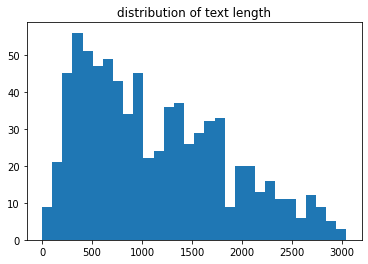

In [24]:
plt.hist(data_explore_df["text_length"], bins=30)
plt.title("distribution of text length")
plt.show()

Let's look at the distribution of party affiliation

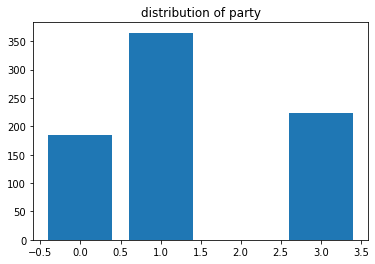

In [25]:
party_count = data_explore_df.groupby(["party"]).count()
party_count["names"] = ["Dem","Rep","Ind"]
ax = plt.subplot()
ax.bar(party_count.index, party_count["text"])
plt.title("distribution of party")
plt.show()

Look at the distribution of status values

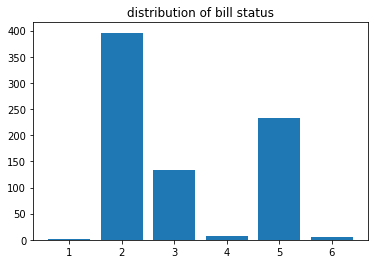

In [26]:
status_count = data_explore_df.groupby(["status"]).count()
ax_s = plt.subplot()
ax_s.bar(status_count.index, status_count["text"])
plt.title("distribution of bill status")
plt.show()

Distribution of encoding lengths

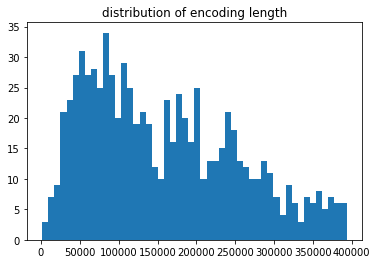

In [27]:
plt.hist(data_explore_df["encoding_length"], bins=50)
plt.title("distribution of encoding length")
plt.show()

Text length vs Encoding Length

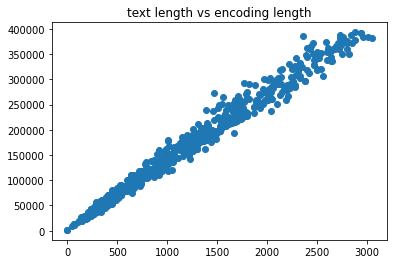

In [28]:
plt.scatter(data_explore_df["text_length"], data_explore_df["encoding_length"])
plt.title("text length vs encoding length")
plt.show()

Which file has the max text length and lets read it in

In [29]:
file_name = data_explore_df["file_name"][data_explore_df["text_length"].idxmax()]

In [30]:
max_length_file = pd.read_pickle(os.path.join(token_path, file_name), compression="gzip")

In [31]:
max_length_file["text"][0]

'transfer pathways it is the intent of the general court that community college students who wish to earn baccalaureate degrees in the state s public higher education system be provided with clear and effective information and directions that specify curricular paths to a degree a the trustees of the university system of new hampshire shall work collaboratively with the trustees of the community college system of new hampshire to create and maintain transfer pathways that optimize the utility and affordability of the community college system for at least the undergraduate majors for which the demand from students in the community college system is the highest and for which pathways can reasonably be created through partnership between the systems b the pathways shall consist of general education and lower division major requirements at participating community college system institutions that are fully transferable as a block upon completion of an associate of science or associate of ar

In [32]:
len(max_length_file["text"][0])

3044

party vs status

In [33]:
data_explore_df.groupby(["party","status"]).size()

party  status
0      2         133
       3          14
       5          37
       6           1
1      1           1
       2         181
       3          76
       4           3
       5         101
       6           3
3      2          82
       3          43
       4           4
       5          94
       6           1
dtype: int64

We will look at cosine similarity between our 2048 vectors from each set of shrunk inputs. This will give a sense of how much of the inputs are similar to each other. Values near 1 or -1 would indicate very similar vectors.

In [38]:
# get an array of the shrunk tensors
import numpy as np
shrunk_array_df_path = "text_shrunk_array.df"
shrunk_array_df = None
if not os.path.exists(shrunk_array_df_path):
    for root, dirs, files in os.walk(token_path):
        for f in files:
            if fnmatch.fnmatch(f, "summary_bill_text*shrunk*"):
                print(f)
                df = pd.read_pickle(os.path.join(root, f), compression="gzip")
                shrunk_encoding = np.array(df["input_shrunk"])
                file_df = pd.DataFrame({"input_shrunk": [shrunk_encoding], "party": [df["party"][0]]})
                #  print(file_df)
                if shrunk_array_df is None:
                    print("initializing")
                    shrunk_array_df = file_df
                else:
                    print("appending")
                    shrunk_array_df = pd.concat([shrunk_array_df, file_df], ignore_index=True)
    shrunk_array_df.to_pickle(shrunk_array_df_path,compression="gzip")
else:
    print("loading existing file")
    shrunk_array_df = pd.read_pickle(shrunk_array_df_path, compression="gzip")

summary_bill_text_1811_1392984-shrunk.pkl
initializing
summary_bill_text_1811_1392985-shrunk.pkl
appending
summary_bill_text_1811_1392986-shrunk.pkl
appending
summary_bill_text_1811_1392988-shrunk.pkl
appending
summary_bill_text_1811_1392991-shrunk.pkl
appending
summary_bill_text_1811_1392992-shrunk.pkl
appending
summary_bill_text_1811_1392995-shrunk.pkl
appending
summary_bill_text_1811_1392996-shrunk.pkl
appending
summary_bill_text_1811_1393001-shrunk.pkl
appending
summary_bill_text_1811_1393003-shrunk.pkl
appending
summary_bill_text_1811_1393010-shrunk.pkl
appending
summary_bill_text_1811_1393013-shrunk.pkl
appending
summary_bill_text_1811_1393014-shrunk.pkl
appending
summary_bill_text_1811_1393017-shrunk.pkl
appending
summary_bill_text_1811_1393019-shrunk.pkl
appending
summary_bill_text_1811_1393020-shrunk.pkl
appending
summary_bill_text_1811_1393023-shrunk.pkl
appending
summary_bill_text_1811_1393024-shrunk.pkl
appending
summary_bill_text_1811_1393030-shrunk.pkl
appending
summary_b

In [39]:
shrunk_array_df.columns
shrunk_encodings = np.asarray([np.asarray(x[0]) for x in shrunk_array_df["input_shrunk"]])

In [40]:
shrunk_encodings.shape

(774, 2048)

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
dist_matrix = cosine_similarity(shrunk_encodings)

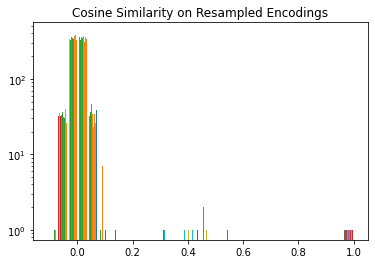

In [43]:
plt.hist(dist_matrix, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity on Resampled Encodings")
plt.show()

Let's do the same for the maxpool data

In [51]:
import numpy as np
maxpool_array_df_path = "text_maxpool_array.df"
maxpool_array_df = None
if not os.path.exists(maxpool_array_df_path):
    for root, dirs, files in os.walk(token_path):
        for f in files:
            if fnmatch.fnmatch(f, "summary_bill_text*maxpool*"):
                print(f)
                df = pd.read_pickle(os.path.join(root, f), compression="gzip")
                maxpool_encoding = np.array(df["input_maxpool"])
                file_df = pd.DataFrame({"input_maxpool": [maxpool_encoding], "party": [df["party"][0]]})
                print(file_df.shape)
                if maxpool_array_df is None:
                    print("initializing")
                    maxpool_array_df = file_df
                else:
                    print("appending")
                    maxpool_array_df = pd.concat([maxpool_array_df, file_df], ignore_index=True)
    maxpool_array_df.to_pickle(maxpool_array_df_path,compression="gzip")
else:
    print("loading existing file")
    maxpool_array_df = pd.read_pickle(maxpool_array_df_path, compression="gzip")

summary_bill_text_1811_1392984-maxpool.pkl
(1, 2)
initializing
summary_bill_text_1811_1392985-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392986-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392988-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392991-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392992-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392995-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392996-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1393001-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1393003-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1393010-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1393013-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1393014-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1393017-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1393019-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1393020-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1393023-maxpoo

In [52]:
maxpool_array_df.head(5)

,input_maxpool,party
0,"[[tensor(0.8261), tensor(5.0339), tensor(2.216...",1
1,"[[tensor(0.7617), tensor(5.9445), tensor(2.626...",1
2,"[[tensor(0.8041), tensor(5.0348), tensor(2.409...",1
3,"[[tensor(4.2714), tensor(1.8018), tensor(2.787...",3
4,"[[tensor(0.7400), tensor(4.2475), tensor(1.740...",1


In [53]:
maxpool_encodings = np.asarray([np.asarray(x[0]) for x in maxpool_array_df["input_maxpool"]])

In [55]:
maxpool_dist_matrix = cosine_similarity(maxpool_encodings)

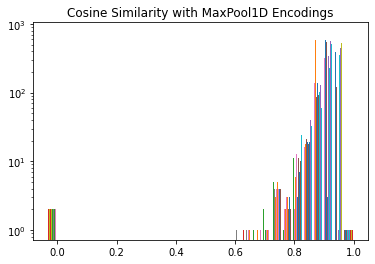

In [56]:
plt.hist(maxpool_dist_matrix, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity with MaxPool1D Encodings")
plt.show()

What is being plotted on the x-axis is the cosine(theta). Which means 0 is unrelated and 1 is related. While the maxpool results seem to show greater spread, a majority of the items show high relatedness. The linear resample has a large peak near zero.

In running the training with the maxpool dataset, the network is not converging. this might indicate that similar inputs are mapping to different outputs and the network is getting 'confused'.

So let's look at the cosine simularties grouped by label pairs. We will take a random sample from each label and look at pairs. We will do this for both the linear resample and the maxpool encodings separately.

In [57]:
shrunk_array_df.groupby(["party"]).count()

,input_shrunk
party,
0,185
1,365
3,224


In [58]:
resamp_party_0_df = shrunk_array_df[shrunk_array_df["party"] == 0].sample(100)
resamp_party_0_encodings = np.asarray([np.asarray(x[0]) for x in resamp_party_0_df["input_shrunk"]])

resamp_party_1_df = shrunk_array_df[shrunk_array_df["party"] == 1].sample(100)
resamp_party_1_encodings = np.asarray([np.asarray(x[0]) for x in resamp_party_1_df["input_shrunk"]])

resamp_party_3_df = shrunk_array_df[shrunk_array_df["party"] == 3].sample(100)
resamp_party_3_encodings = np.asarray([np.asarray(x[0]) for x in resamp_party_3_df["input_shrunk"]])


In [59]:
cosine_0_1 = cosine_similarity(resamp_party_0_encodings, resamp_party_1_encodings)
cosine_0_3 = cosine_similarity(resamp_party_0_encodings, resamp_party_3_encodings)
cosine_1_3 = cosine_similarity(resamp_party_1_encodings, resamp_party_3_encodings)

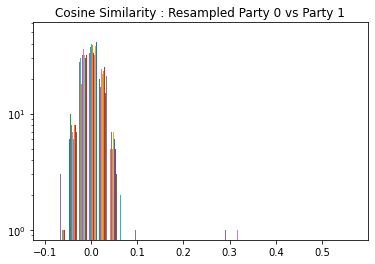

In [60]:
plt.hist(cosine_0_1, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : Resampled Party 0 vs Party 1")
plt.show()

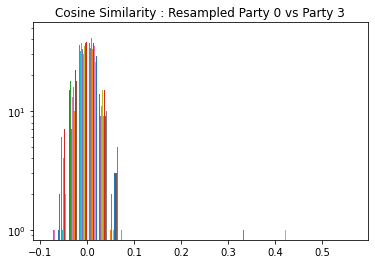

In [61]:
plt.hist(cosine_0_3, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : Resampled Party 0 vs Party 3")
plt.show()

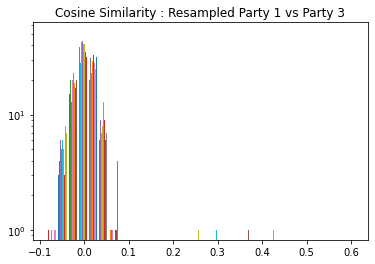

In [62]:
plt.hist(cosine_1_3, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : Resampled Party 1 vs Party 3")
plt.show()

Let's do the same visualiztion for the maxpool data

In [63]:
maxpool_party_0_df = maxpool_array_df[maxpool_array_df["party"] == 0].sample(100)
maxpool_party_0_encodings = np.asarray([np.asarray(x[0]) for x in maxpool_party_0_df["input_maxpool"]])

maxpool_party_1_df = maxpool_array_df[maxpool_array_df["party"] == 1].sample(100)
maxpool_party_1_encodings = np.asarray([np.asarray(x[0]) for x in maxpool_party_1_df["input_maxpool"]])

maxpool_party_3_df = maxpool_array_df[maxpool_array_df["party"] == 3].sample(100)
maxpool_party_3_encodings = np.asarray([np.asarray(x[0]) for x in maxpool_party_3_df["input_maxpool"]])

In [64]:
mp_cosine_0_1 = cosine_similarity(maxpool_party_0_encodings, maxpool_party_1_encodings)
mp_cosine_0_3 = cosine_similarity(maxpool_party_0_encodings, maxpool_party_3_encodings)
mp_cosine_1_3 = cosine_similarity(maxpool_party_1_encodings, maxpool_party_3_encodings)

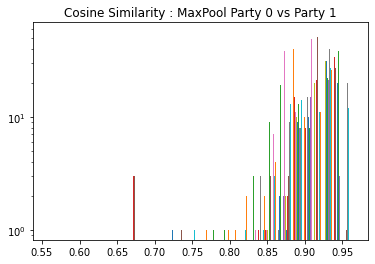

In [65]:
plt.hist(mp_cosine_0_1, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : MaxPool Party 0 vs Party 1")
plt.show()

c:\users\benja\git-projects\bitbucket\nlp_legislation_prediction\venvs3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


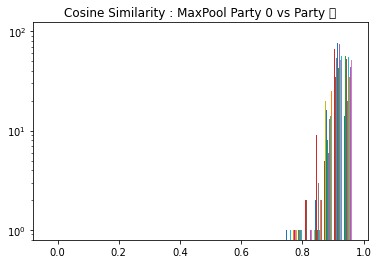

In [66]:
plt.hist(mp_cosine_0_3, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : MaxPool Party 0 vs Party \3")
plt.show()

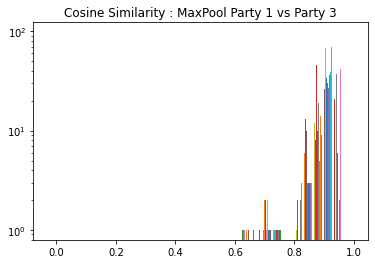

In [67]:
plt.hist(mp_cosine_1_3, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : MaxPool Party 1 vs Party 3")
plt.show()

Breaking the comparisons down by party label pairs don't change the overall features of the distributions. The maxpool ones still show tendency to higher similiarity.

So we will run the training against the resampled data instead.

---
I still have concern that there is not enough separation between the different label pairs. Thinking that maybe I'm loosing too much information by going to 2048 elements, I've prepared a 4096 element version

In [70]:
# get an array of the shrunk tensors
import numpy as np
shrunk_array_df_path = "text_shrunk_array_4096.df"
shrunk_array_4096_df = None
if not os.path.exists(shrunk_array_df_path):
    for root, dirs, files in os.walk(token_path):
        for f in files:
            if fnmatch.fnmatch(f, "summary_bill_text*shrunk*"):
                print(f)
                df = pd.read_pickle(os.path.join(root, f), compression="gzip")
                shrunk_encoding = np.array(df["input_shrunk"])
                file_df = pd.DataFrame({"input_shrunk": [shrunk_encoding], "party": [df["party"][0]]})
                #  print(file_df)
                if shrunk_array_4096_df is None:
                    print("initializing")
                    shrunk_array_4096_df = file_df
                else:
                    print("appending")
                    shrunk_array_4096_df = pd.concat([shrunk_array_df, file_df], ignore_index=True)
    shrunk_array_4096_df.to_pickle(shrunk_array_df_path,compression="gzip")
else:
    print("loading existing file")
    shrunk_array_4096_df = pd.read_pickle(shrunk_array_df_path, compression="gzip")

summary_bill_text_1811_1392984-shrunk-4096.pkl
initializing
summary_bill_text_1811_1392984-shrunk.pkl
appending
summary_bill_text_1811_1392985-shrunk-4096.pkl
appending
summary_bill_text_1811_1392985-shrunk.pkl
appending
summary_bill_text_1811_1392986-shrunk-4096.pkl
appending
summary_bill_text_1811_1392986-shrunk.pkl
appending
summary_bill_text_1811_1392988-shrunk-4096.pkl
appending
summary_bill_text_1811_1392988-shrunk.pkl
appending
summary_bill_text_1811_1392991-shrunk-4096.pkl
appending
summary_bill_text_1811_1392991-shrunk.pkl
appending
summary_bill_text_1811_1392992-shrunk-4096.pkl
appending
summary_bill_text_1811_1392992-shrunk.pkl
appending
summary_bill_text_1811_1392995-shrunk-4096.pkl
appending
summary_bill_text_1811_1392995-shrunk.pkl
appending
summary_bill_text_1811_1392996-shrunk-4096.pkl
appending
summary_bill_text_1811_1392996-shrunk.pkl
appending
summary_bill_text_1811_1393001-shrunk-4096.pkl
appending
summary_bill_text_1811_1393001-shrunk.pkl
appending
summary_bill_tex

In [72]:
shrunk_array_4096_df.columns
shrunk_encodings = np.asarray([np.asarray(x[0]) for x in shrunk_array_4096_df["input_shrunk"]])
dist_matrix_4096 = cosine_similarity(shrunk_encodings)

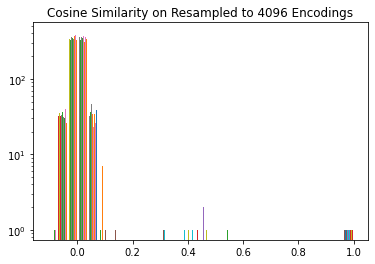

In [73]:
plt.hist(dist_matrix, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity on Resampled to 4096 Encodings")
plt.show()

In [74]:
resamp_party_0_df = shrunk_array_4096_df[shrunk_array_4096_df["party"] == 0].sample(100)
resamp_party_0_encodings = np.asarray([np.asarray(x[0]) for x in resamp_party_0_df["input_shrunk"]])

resamp_party_1_df = shrunk_array_4096_df[shrunk_array_4096_df["party"] == 1].sample(100)
resamp_party_1_encodings = np.asarray([np.asarray(x[0]) for x in resamp_party_1_df["input_shrunk"]])

resamp_party_3_df = shrunk_array_4096_df[shrunk_array_4096_df["party"] == 3].sample(100)
resamp_party_3_encodings = np.asarray([np.asarray(x[0]) for x in resamp_party_3_df["input_shrunk"]])

cosine_0_1 = cosine_similarity(resamp_party_0_encodings, resamp_party_1_encodings)
cosine_0_3 = cosine_similarity(resamp_party_0_encodings, resamp_party_3_encodings)
cosine_1_3 = cosine_similarity(resamp_party_1_encodings, resamp_party_3_encodings)

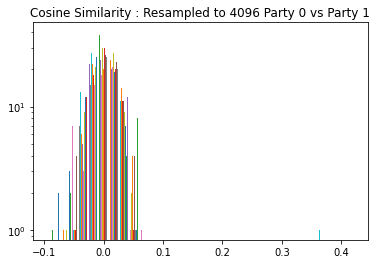

In [75]:
plt.hist(cosine_0_1, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : Resampled to 4096 Party 0 vs Party 1")
plt.show()

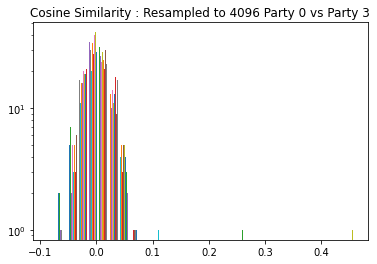

In [76]:
plt.hist(cosine_0_3, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : Resampled to 4096 Party 0 vs Party 3")
plt.show()

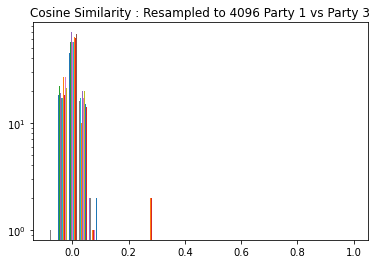

In [77]:
plt.hist(cosine_1_3, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : Resampled to 4096 Party 1 vs Party 3")
plt.show()

In [78]:
import numpy as np
maxpool_array_4096_df_path = "text_maxpool_array_4096.df"
maxpool_array_4096_df = None
if not os.path.exists(maxpool_array_4096_df_path):
    for root, dirs, files in os.walk(token_path):
        for f in files:
            if fnmatch.fnmatch(f, "summary_bill_text*maxpool*"):
                print(f)
                df = pd.read_pickle(os.path.join(root, f), compression="gzip")
                maxpool_encoding = np.array(df["input_maxpool"])
                file_df = pd.DataFrame({"input_maxpool": [maxpool_encoding], "party": [df["party"][0]]})
                print(file_df.shape)
                if maxpool_array_4096_df is None:
                    print("initializing")
                    maxpool_array_4096_df = file_df
                else:
                    print("appending")
                    maxpool_array_4096_df = pd.concat([maxpool_array_df, file_df], ignore_index=True)
    maxpool_array_4096_df.to_pickle(maxpool_array_df_path,compression="gzip")
else:
    print("loading existing file")
    maxpool_array_4096_df = pd.read_pickle(maxpool_array_df_path, compression="gzip")

summary_bill_text_1811_1392984-maxpool-4096.pkl
(1, 2)
initializing
summary_bill_text_1811_1392984-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392985-maxpool-4096.pkl
(1, 2)
appending
summary_bill_text_1811_1392985-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392986-maxpool-4096.pkl
(1, 2)
appending
summary_bill_text_1811_1392986-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392988-maxpool-4096.pkl
(1, 2)
appending
summary_bill_text_1811_1392988-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392991-maxpool-4096.pkl
(1, 2)
appending
summary_bill_text_1811_1392991-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392992-maxpool-4096.pkl
(1, 2)
appending
summary_bill_text_1811_1392992-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392995-maxpool-4096.pkl
(1, 2)
appending
summary_bill_text_1811_1392995-maxpool.pkl
(1, 2)
appending
summary_bill_text_1811_1392996-maxpool-4096.pkl
(1, 2)
appending
summary_bill_text_1811_1392996-maxpool.pkl
(1, 2)
appendi

In [79]:
maxpool_array_4096_df = np.asarray([np.asarray(x[0]) for x in maxpool_array_4096_df["input_maxpool"]])

maxpool_dist_4096_matrix = cosine_similarity(maxpool_array_4096_df)

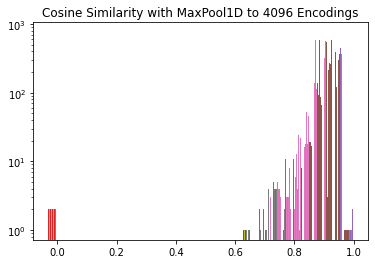

In [80]:
plt.hist(maxpool_dist_4096_matrix, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity with MaxPool1D to 4096 Encodings")
plt.show()

Now look at 8192 element encodings

In [83]:
shrunk_array_8192_df_path = "text_shrunk_array_8192.df"
shrunk_array_8192_df = None
if not os.path.exists(shrunk_array_8192_df_path):
    for root, dirs, files in os.walk(token_path):
        for f in files:
            if fnmatch.fnmatch(f, "summary_bill_text*shrunk*8192*"):
                print(f)
                df = pd.read_pickle(os.path.join(root, f), compression="gzip")
                shrunk_encoding = np.array(df["input_shrunk"])
                file_df = pd.DataFrame({"input_shrunk": [shrunk_encoding], "party": [df["party"][0]]})
                #  print(file_df)
                if shrunk_array_8192_df is None:
                    print("initializing")
                    shrunk_array_8192_df = file_df
                else:
                    print("appending")
                    shrunk_array_8192_df = pd.concat([shrunk_array_8192_df, file_df], ignore_index=True)
    shrunk_array_8192_df.to_pickle(shrunk_array_df_path,compression="gzip")
else:
    print("loading existing file")
    shrunk_array_8192_df = pd.read_pickle(shrunk_array_df_path, compression="gzip")

summary_bill_text_1811_1392984-shrunk-8192.pkl
initializing
summary_bill_text_1811_1392985-shrunk-8192.pkl
appending
summary_bill_text_1811_1392986-shrunk-8192.pkl
appending
summary_bill_text_1811_1392988-shrunk-8192.pkl
appending
summary_bill_text_1811_1392991-shrunk-8192.pkl
appending
summary_bill_text_1811_1392992-shrunk-8192.pkl
appending
summary_bill_text_1811_1392995-shrunk-8192.pkl
appending
summary_bill_text_1811_1392996-shrunk-8192.pkl
appending
summary_bill_text_1811_1393001-shrunk-8192.pkl
appending
summary_bill_text_1811_1393003-shrunk-8192.pkl
appending
summary_bill_text_1811_1393010-shrunk-8192.pkl
appending
summary_bill_text_1811_1393013-shrunk-8192.pkl
appending
summary_bill_text_1811_1393014-shrunk-8192.pkl
appending
summary_bill_text_1811_1393017-shrunk-8192.pkl
appending
summary_bill_text_1811_1393019-shrunk-8192.pkl
appending
summary_bill_text_1811_1393020-shrunk-8192.pkl
appending
summary_bill_text_1811_1393023-shrunk-8192.pkl
appending
summary_bill_text_1811_13930

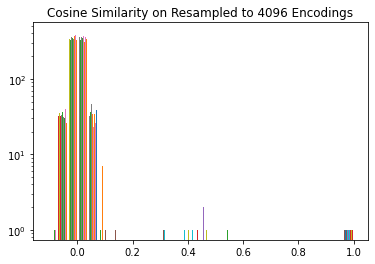

In [84]:
shrunk_encodings = np.asarray([np.asarray(x[0]) for x in shrunk_array_8192_df["input_shrunk"]])
dist_matrix_4096 = cosine_similarity(shrunk_encodings)
plt.hist(dist_matrix, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity on Resampled to 4096 Encodings")
plt.show()

In [87]:
resamp_party_0_8192_df = shrunk_array_8192_df[shrunk_array_8192_df["party"] == 0].sample(100)
resamp_party_0_8192_encodings = np.asarray([np.asarray(x[0]) for x in resamp_party_0_8192_df["input_shrunk"]])

resamp_party_1_8192_df = shrunk_array_8192_df[shrunk_array_8192_df["party"] == 1].sample(100)
resamp_party_1_8192_encodings = np.asarray([np.asarray(x[0]) for x in resamp_party_1_8192_df["input_shrunk"]])

resamp_party_3_8192_df = shrunk_array_8192_df[shrunk_array_8192_df["party"] == 3].sample(100)
resamp_party_3_8192_encodings = np.asarray([np.asarray(x[0]) for x in resamp_party_3_8192_df["input_shrunk"]])

cosine_0_1_8192 = cosine_similarity(resamp_party_0_8192_encodings, resamp_party_1_8192_encodings)
cosine_0_3_8192 = cosine_similarity(resamp_party_0_8192_encodings, resamp_party_3_8192_encodings)
cosine_1_3_8192 = cosine_similarity(resamp_party_1_8192_encodings, resamp_party_3_8192_encodings)

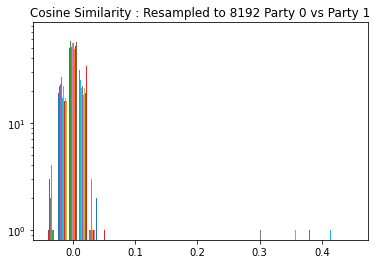

In [88]:
plt.hist(cosine_0_1_8192, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : Resampled to 8192 Party 0 vs Party 1")
plt.show()

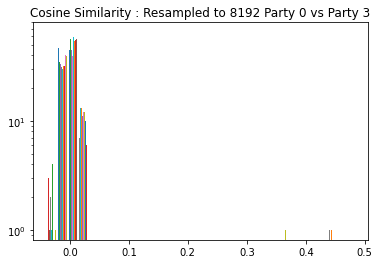

In [89]:
plt.hist(cosine_0_3_8192, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : Resampled to 8192 Party 0 vs Party 3")
plt.show()

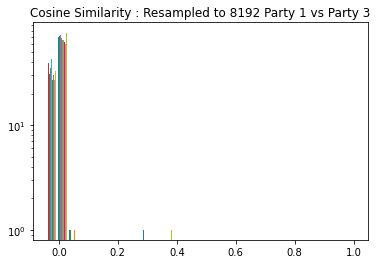

In [90]:
plt.hist(cosine_1_3_8192, bins=30)
plt.yscale('log')
plt.title("Cosine Similarity : Resampled to 8192 Party 1 vs Party 3")
plt.show()